In [ ]:
!unzip BearCart_Cleaned_Dataset.zip


Archive:  BearCart_Cleaned_Dataset.zip
   creating: Cleaned_Dataset/
  inflating: Cleaned_Dataset/cleaned_refunds.csv  
  inflating: Cleaned_Dataset/cleaned_pageviews.csv  
  inflating: Cleaned_Dataset/cleaned_sessions.csv  
  inflating: Cleaned_Dataset/cleaned_products.csv  
  inflating: Cleaned_Dataset/cleaned_order_items.csv  
  inflating: Cleaned_Dataset/cleaned_orders.csv  


In [ ]:
products_cleaned = pd.read_csv(
    "Cleaned_Dataset/cleaned_products.csv",
    parse_dates=["created_at"]
)

orders_cleaned = pd.read_csv(
    "Cleaned_Dataset/cleaned_orders.csv",
    parse_dates=["created_at"]
)

order_items_cleaned = pd.read_csv(
    "Cleaned_Dataset/cleaned_order_items.csv",
    parse_dates=["created_at"]
)

refunds_cleaned = pd.read_csv(
    "Cleaned_Dataset/cleaned_refunds.csv",
    parse_dates=["created_at"]
)

sessions_cleaned = pd.read_csv(
    "Cleaned_Dataset/cleaned_sessions.csv",
    parse_dates=["created_at"]
)

pageviews_cleaned = pd.read_csv(
    "Cleaned_Dataset/cleaned_pageviews.csv",
    parse_dates=["created_at"]
)


In [ ]:
print("Orders:", orders_cleaned.shape)
print("Sessions:", sessions_cleaned.shape)
print("Order Items:", order_items_cleaned.shape)
print("Refunds:", refunds_cleaned.shape)
print("Products:", products_cleaned.shape)
print("Pageviews:", pageviews_cleaned.shape)


Orders: (32313, 9)
Sessions: (472871, 9)
Order Items: (40025, 7)
Refunds: (1731, 5)
Products: (4, 3)
Pageviews: (1188124, 4)


In [ ]:
orders_cleaned.columns


Index(['order_id', 'created_at', 'website_session_id', 'user_id',
       'primary_product_id', 'items_purchased', 'price_usd', 'cogs_usd',
       'price_mismatch_flag'],
      dtype='object')

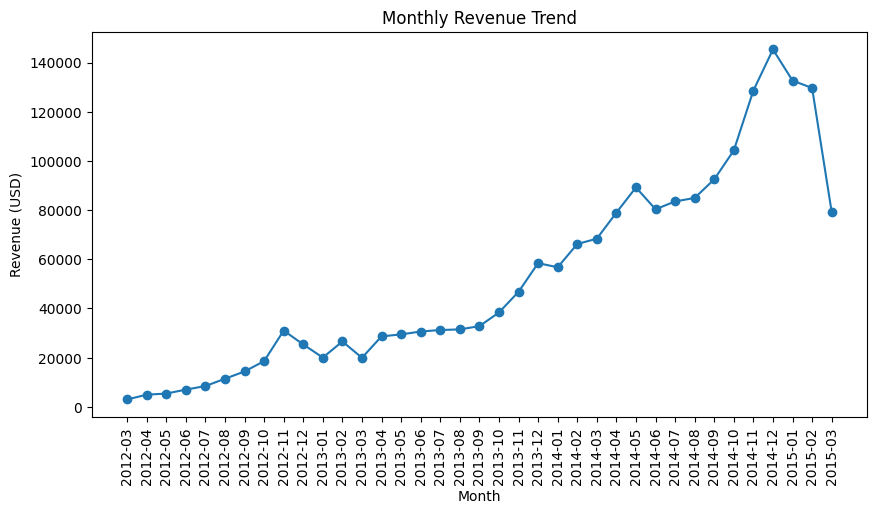

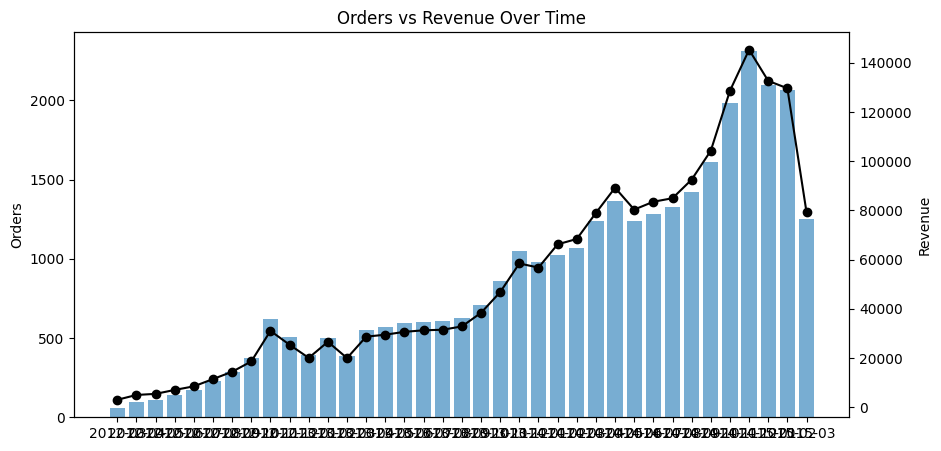

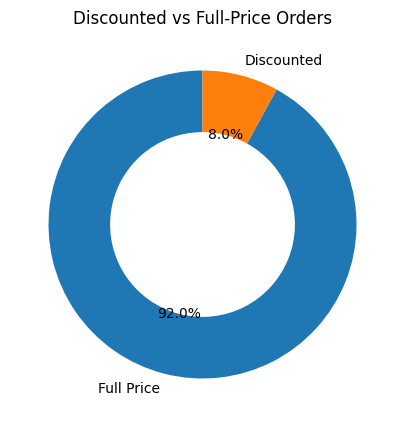

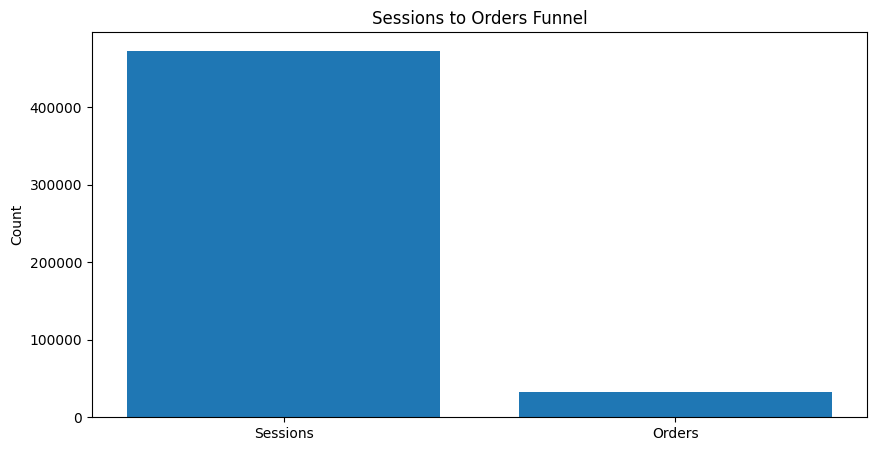

In [ ]:
total_sessions = sessions_cleaned["website_session_id"].nunique()
total_orders = orders_cleaned["order_id"].nunique()

plt.bar(["Sessions", "Orders"], [total_sessions, total_orders])
plt.title("Sessions to Orders Funnel")
plt.ylabel("Count")
plt.show()


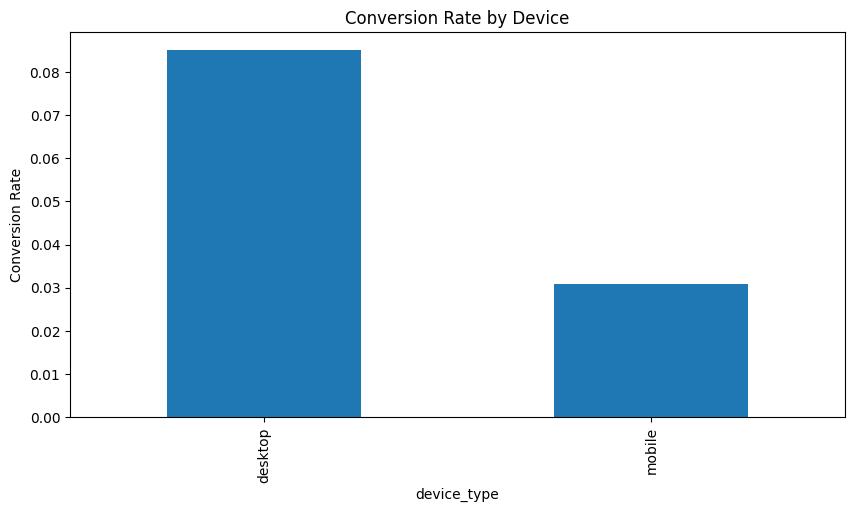

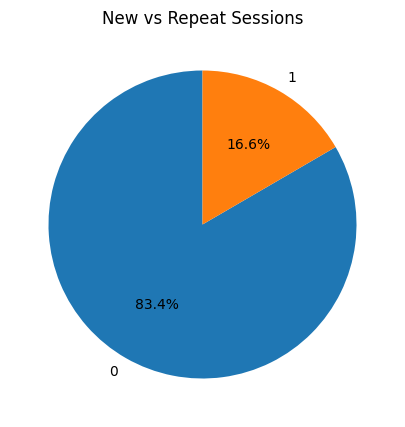

In [ ]:
sessions_cleaned["is_repeat_session"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90
)
plt.title("New vs Repeat Sessions")
plt.ylabel("")
plt.show()


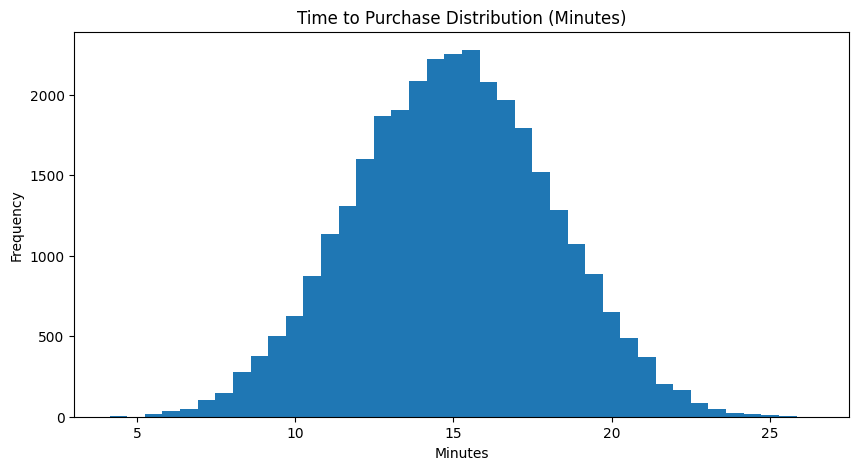

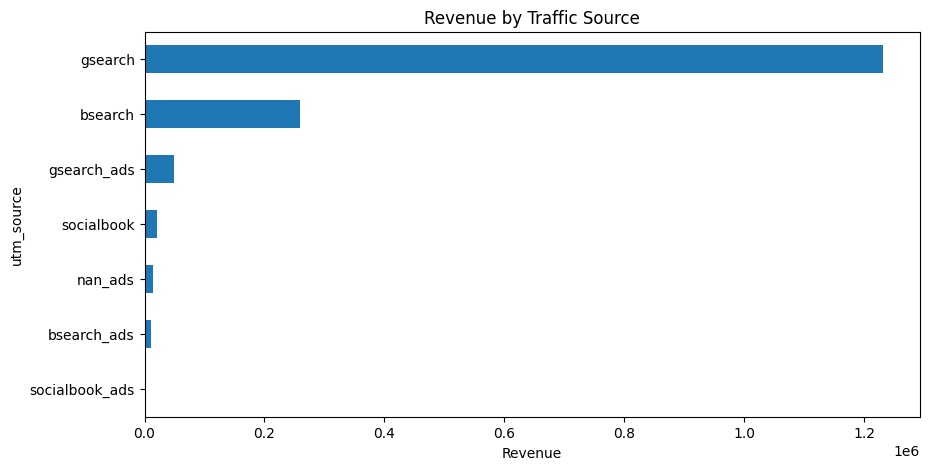

In [ ]:
source_revenue = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id")
    .groupby("utm_source")["price_usd"]
    .sum()
    .sort_values()
)

source_revenue.plot(kind="barh")
plt.title("Revenue by Traffic Source")
plt.xlabel("Revenue")
plt.show()


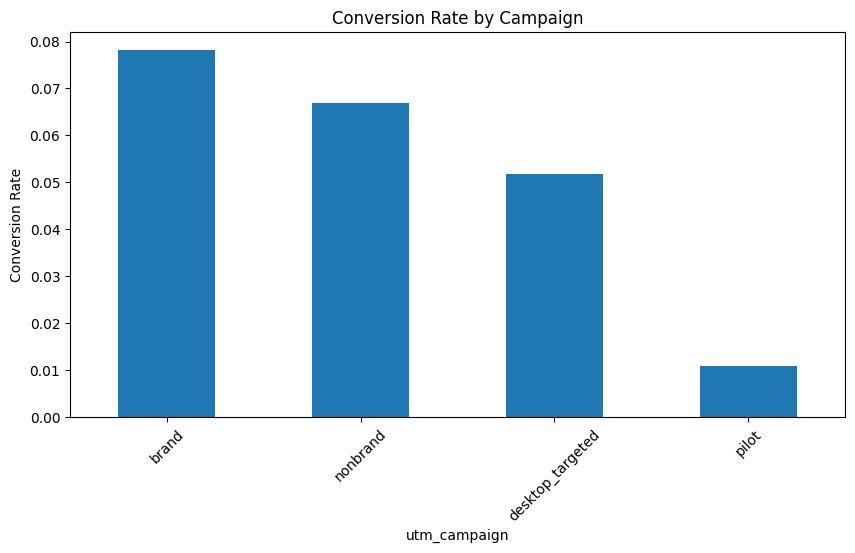

In [ ]:
campaign_conversion = (
    session_orders
    .groupby("utm_campaign")["order_id"]
    .apply(lambda x: x.notnull().mean())
    .sort_values(ascending=False)
)

campaign_conversion.plot(kind="bar")
plt.title("Conversion Rate by Campaign")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.show()


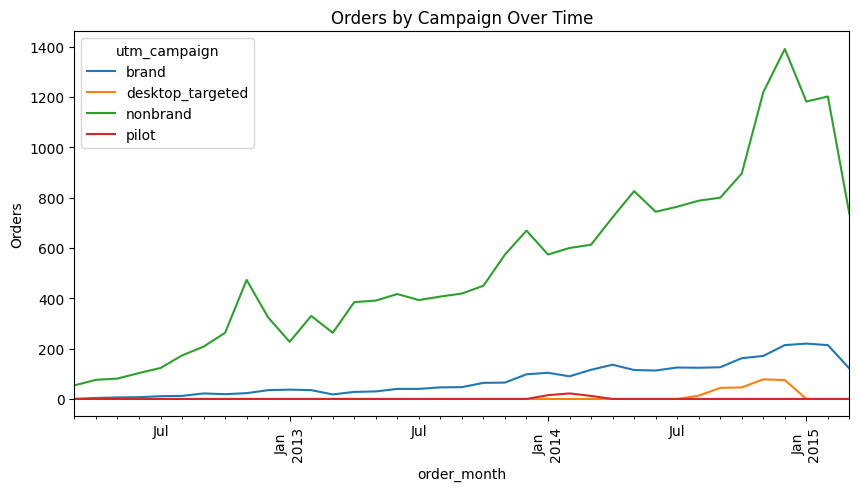

In [ ]:
campaign_trend = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id")
    .assign(order_month=lambda df: df["created_at_y"].dt.to_period("M"))
    .groupby(["order_month", "utm_campaign"])
    .size()
    .unstack(fill_value=0)
)

campaign_trend.plot()
plt.title("Orders by Campaign Over Time")
plt.ylabel("Orders")
plt.xticks(rotation=90)
plt.show()


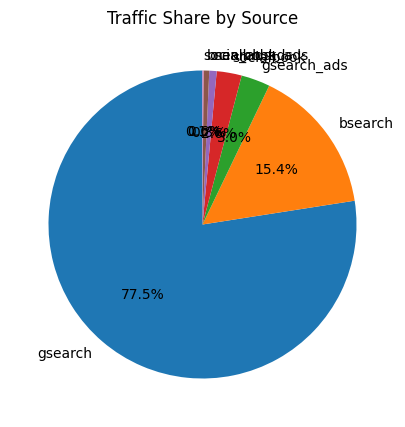

In [ ]:
sessions_cleaned["utm_source"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Traffic Share by Source")
plt.ylabel("")
plt.show()


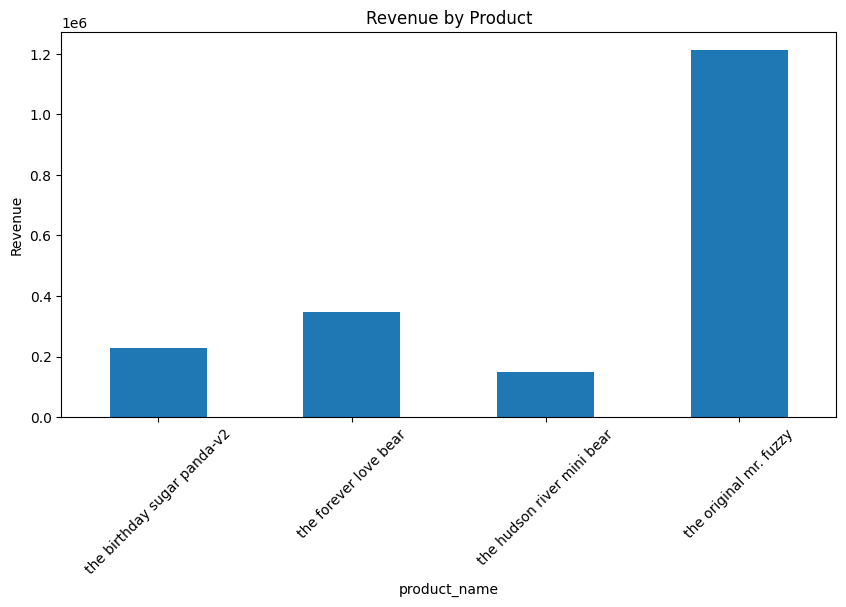

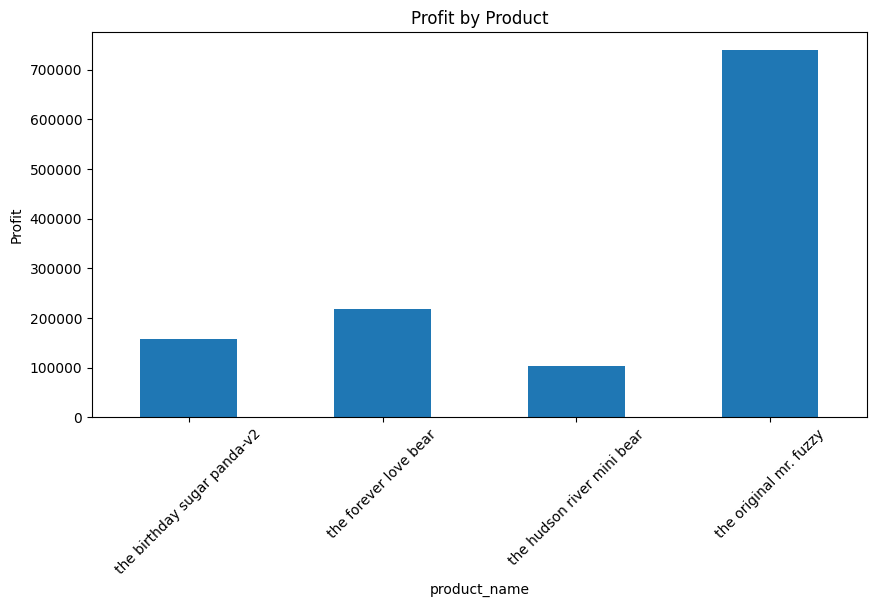

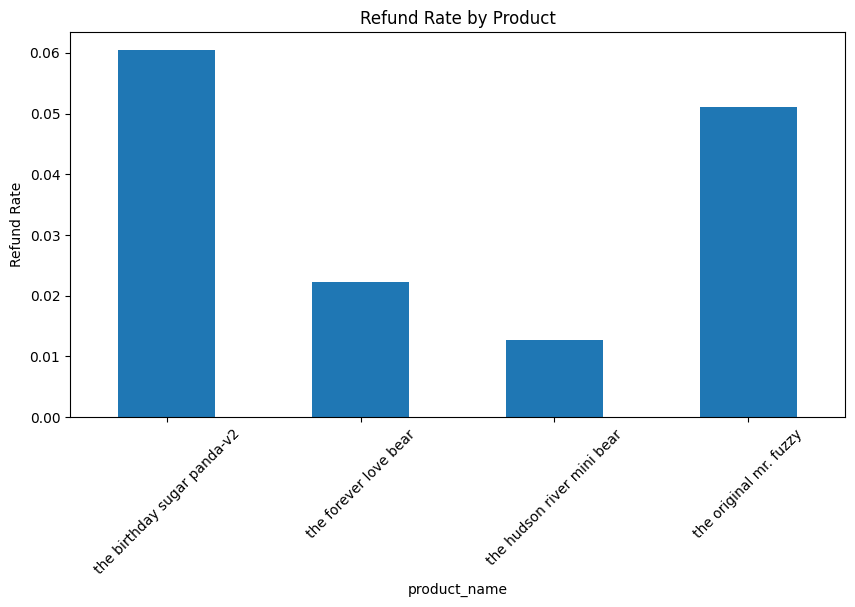

In [ ]:
refunds_with_products = (
    refunds_cleaned
    .merge(order_items_cleaned, on="order_item_id")
    .merge(products_cleaned, on="product_id")
)

refund_rate = (
    refunds_with_products
    .groupby("product_name")["order_item_id"]
    .count()
    /
    order_items_cleaned
    .merge(products_cleaned, on="product_id")
    .groupby("product_name")["order_item_id"]
    .count()
)

refund_rate.plot(kind="bar")
plt.title("Refund Rate by Product")
plt.ylabel("Refund Rate")
plt.xticks(rotation=45)
plt.show()


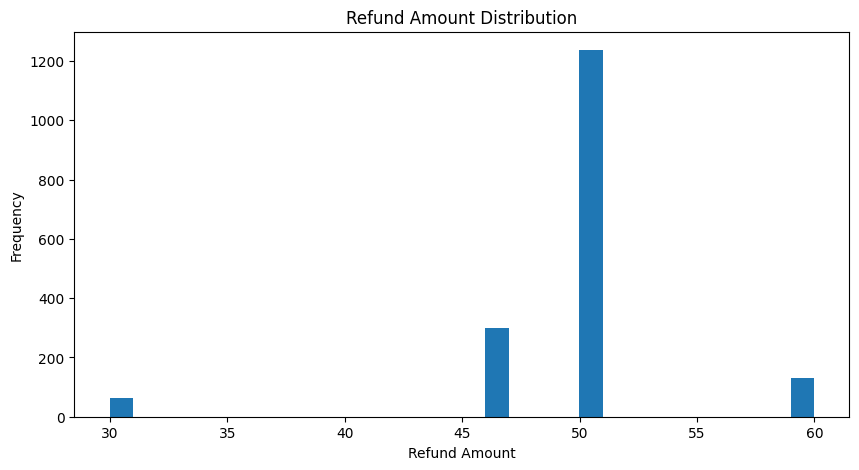

In [ ]:
plt.hist(refunds_cleaned["refund_amount_usd"], bins=30)
plt.title("Refund Amount Distribution")
plt.xlabel("Refund Amount")
plt.ylabel("Frequency")
plt.show()


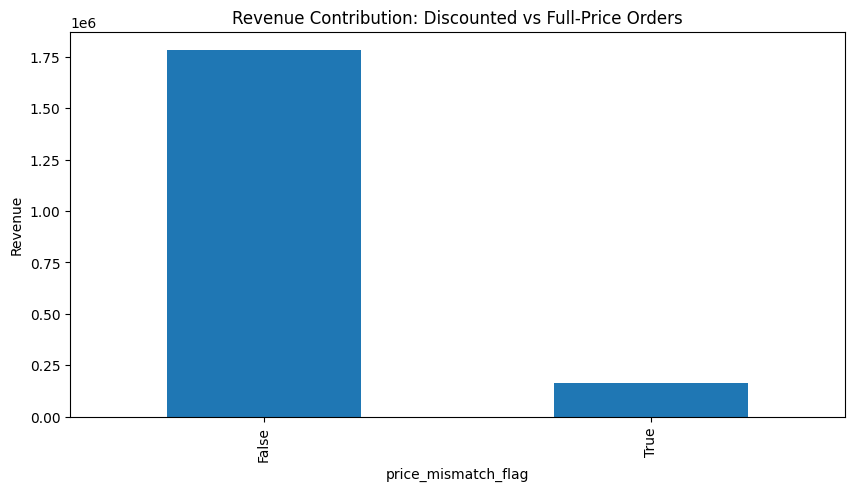

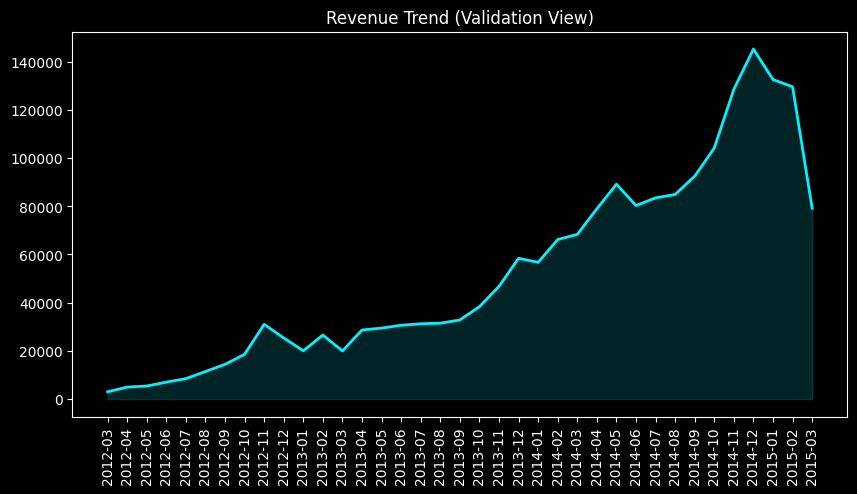

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("dark_background")
sns.set_palette("bright")

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "grid.alpha": 0.15
})


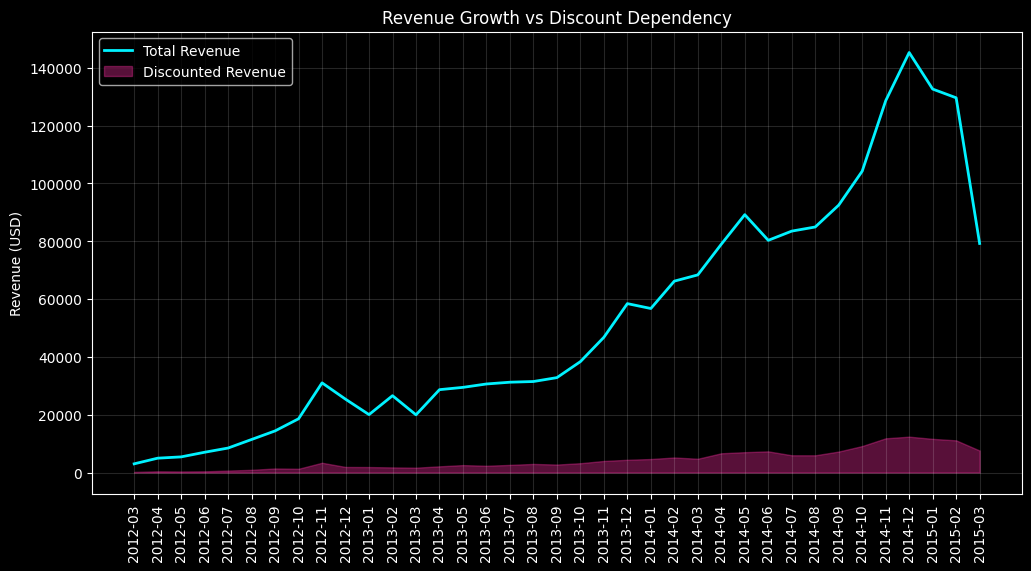

In [ ]:
orders_cleaned["month"] = orders_cleaned["created_at"].dt.to_period("M")

rev_discount = (
    orders_cleaned
    .groupby(["month", "price_mismatch_flag"])["price_usd"]
    .sum()
    .unstack(fill_value=0)
)

rev_discount.index = rev_discount.index.astype(str)

plt.plot(rev_discount.index, rev_discount.sum(axis=1),
         label="Total Revenue", linewidth=2, color="#00f2ff")

plt.fill_between(
    rev_discount.index,
    rev_discount[True],
    alpha=0.35,
    label="Discounted Revenue",
    color="#ff2fa4"
)

plt.title("Revenue Growth vs Discount Dependency")
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=90)
plt.legend()
plt.show()


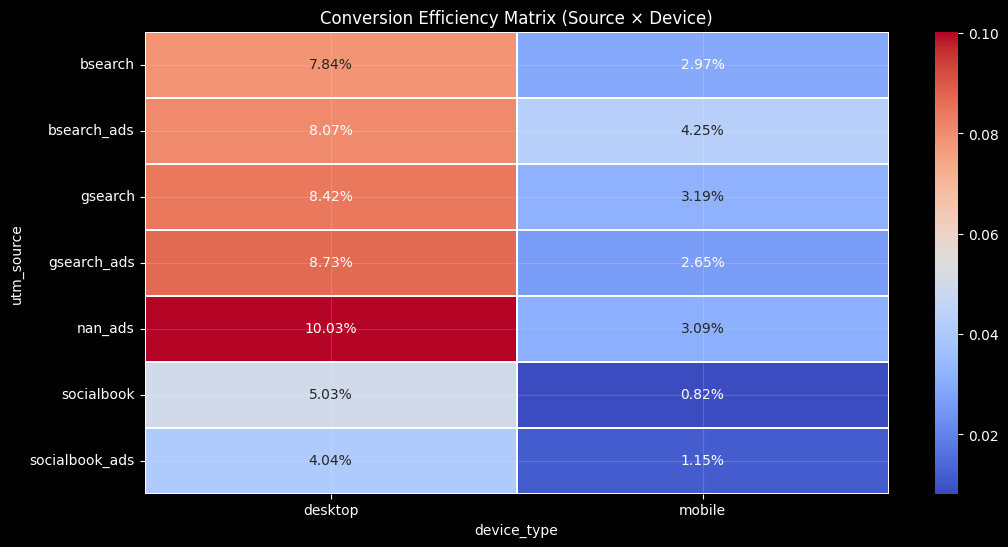

In [ ]:
session_orders = sessions_cleaned.merge(
    orders_cleaned, on="website_session_id", how="left"
)

conversion_matrix = (
    session_orders
    .groupby(["utm_source", "device_type"])["order_id"]
    .apply(lambda x: x.notnull().mean())
    .unstack()
)

sns.heatmap(
    conversion_matrix,
    annot=True,
    fmt=".2%",
    cmap="coolwarm",
    linewidths=0.3
)

plt.title("Conversion Efficiency Matrix (Source × Device)")
plt.show()


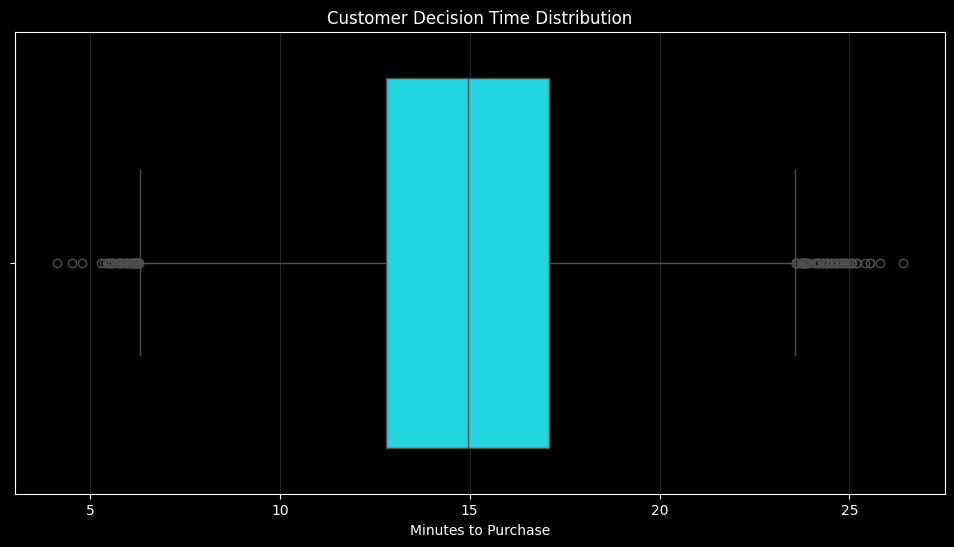

In [ ]:
session_orders_time = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id")
)

session_orders_time["minutes_to_order"] = (
    session_orders_time["created_at_y"] -
    session_orders_time["created_at_x"]
).dt.total_seconds() / 60

sns.boxplot(
    x=session_orders_time["minutes_to_order"],
    color="#00f2ff"
)

plt.title("Customer Decision Time Distribution")
plt.xlabel("Minutes to Purchase")
plt.show()


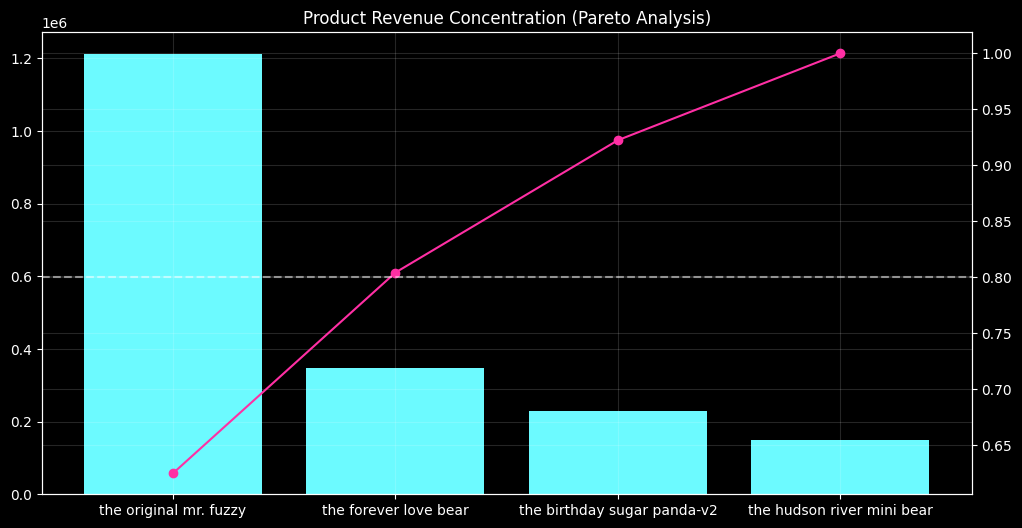

In [ ]:
product_rev = (
    order_items_cleaned
    .merge(products_cleaned, on="product_id")
    .groupby("product_name")["price_usd"]
    .sum()
    .sort_values(ascending=False)
)

cum_share = product_rev.cumsum() / product_rev.sum()

fig, ax1 = plt.subplots()

ax1.bar(product_rev.index, product_rev, color="#6cfaff")
ax2 = ax1.twinx()
ax2.plot(product_rev.index, cum_share, color="#ff2fa4", marker="o")

ax2.axhline(0.8, linestyle="--", alpha=0.5)

plt.title("Product Revenue Concentration (Pareto Analysis)")
plt.xticks(rotation=45)
plt.show()


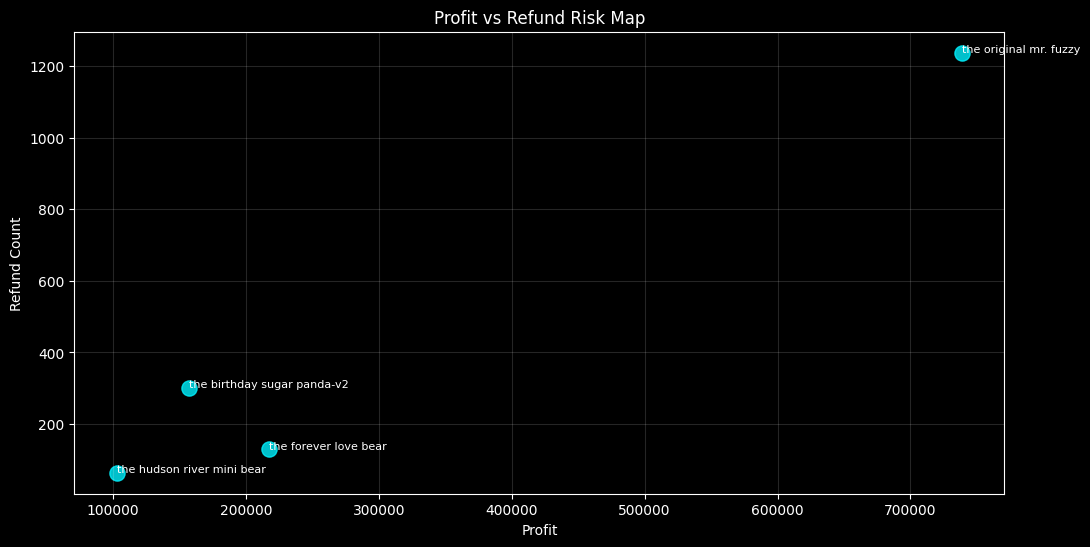

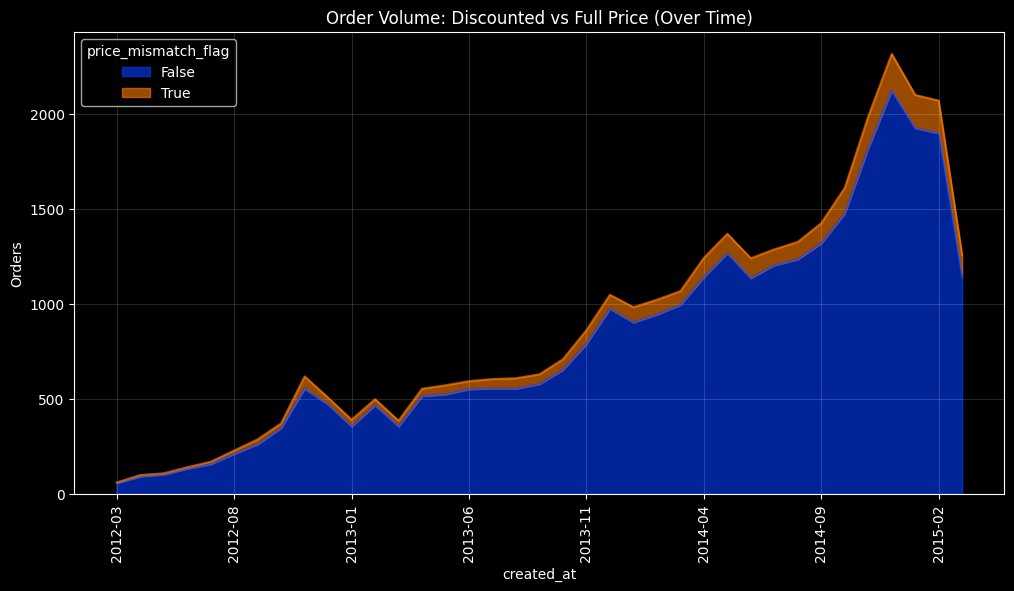

In [ ]:
discount_flow = (
    orders_cleaned
    .groupby([orders_cleaned["created_at"].dt.to_period("M"),
              "price_mismatch_flag"])
    .size()
    .unstack(fill_value=0)
)

discount_flow.index = discount_flow.index.astype(str)

discount_flow.plot(kind="area", stacked=True, alpha=0.6)

plt.title("Order Volume: Discounted vs Full Price (Over Time)")
plt.ylabel("Orders")
plt.xticks(rotation=90)
plt.show()


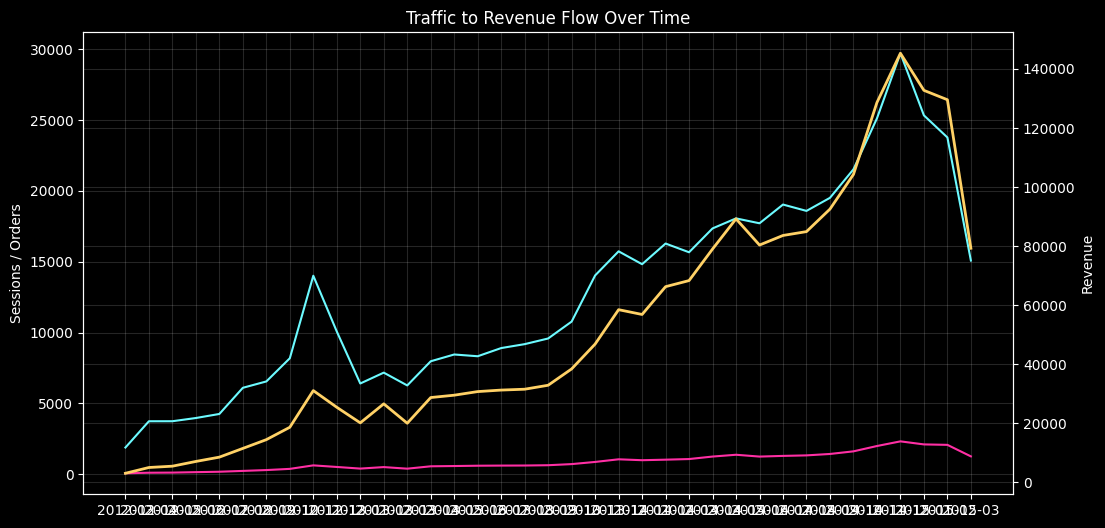

In [ ]:
session_order_rev = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id", how="left")
    .assign(month=lambda df: df["created_at_x"].dt.to_period("M"))
    .groupby("month")
    .agg(
        sessions=("website_session_id", "nunique"),
        orders=("order_id", "nunique"),
        revenue=("price_usd", "sum")
    )
)

fig, ax1 = plt.subplots()

ax1.plot(session_order_rev.index.astype(str),
         session_order_rev["sessions"],
         label="Sessions", color="#6cfaff")

ax1.plot(session_order_rev.index.astype(str),
         session_order_rev["orders"],
         label="Orders", color="#ff2fa4")

ax2 = ax1.twinx()
ax2.plot(session_order_rev.index.astype(str),
         session_order_rev["revenue"],
         label="Revenue", color="#ffd166", linewidth=2)

ax1.set_ylabel("Sessions / Orders")
ax2.set_ylabel("Revenue")

plt.title("Traffic to Revenue Flow Over Time")
plt.xticks(rotation=90)
plt.show()


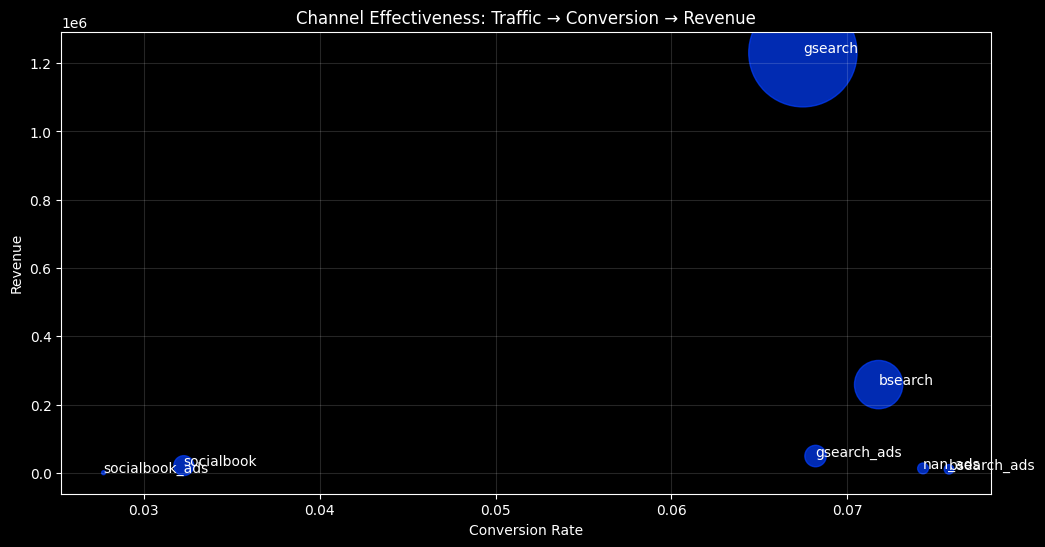

In [ ]:
channel_perf = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id", how="left")
    .groupby("utm_source")
    .agg(
        sessions=("website_session_id", "nunique"),
        orders=("order_id", "nunique"),
        revenue=("price_usd", "sum")
    )
)

channel_perf["conversion_rate"] = (
    channel_perf["orders"] / channel_perf["sessions"]
)

plt.scatter(
    channel_perf["conversion_rate"],
    channel_perf["revenue"],
    s=channel_perf["sessions"] / 50,
    alpha=0.7
)

for i in channel_perf.index:
    plt.annotate(i,
                 (channel_perf.loc[i, "conversion_rate"],
                  channel_perf.loc[i, "revenue"]))

plt.xlabel("Conversion Rate")
plt.ylabel("Revenue")
plt.title("Channel Effectiveness: Traffic → Conversion → Revenue")
plt.show()


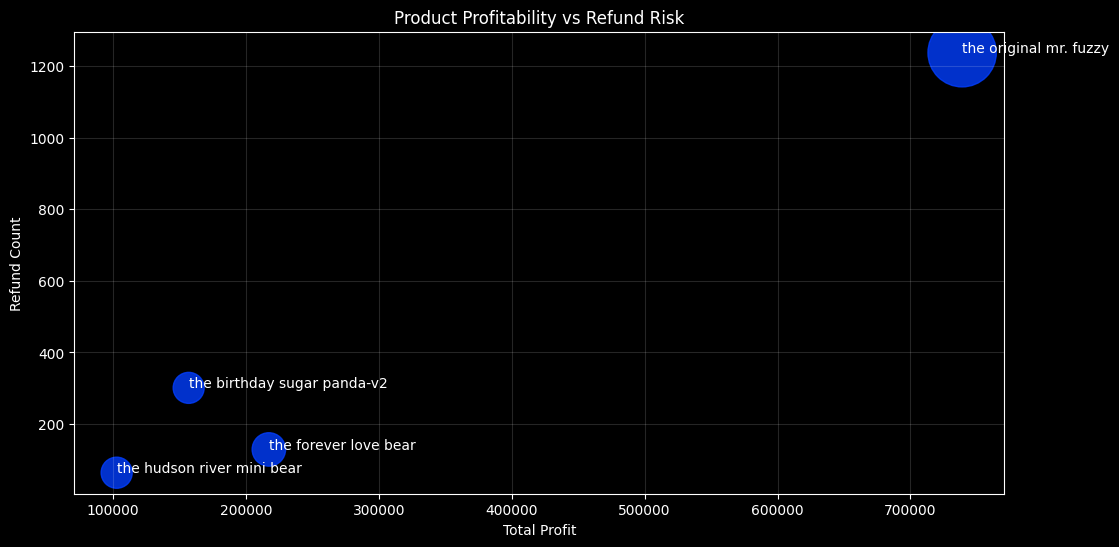

In [ ]:
product_metrics = (
    order_items_cleaned
    .merge(products_cleaned, on="product_id")
    .assign(profit=lambda df: df["price_usd"] - df["cogs_usd"])
    .groupby("product_name")
    .agg(
        total_profit=("profit", "sum"),
        units_sold=("order_item_id", "count")
    )
)

refund_counts = (
    refunds_cleaned
    .merge(order_items_cleaned, on="order_item_id")
    .merge(products_cleaned, on="product_id")
    .groupby("product_name")
    .size()
)

product_metrics["refunds"] = refund_counts
product_metrics = product_metrics.fillna(0)

plt.scatter(
    product_metrics["total_profit"],
    product_metrics["refunds"],
    s=product_metrics["units_sold"] / 10,
    alpha=0.8
)

for name in product_metrics.index:
    plt.annotate(name,
                 (product_metrics.loc[name, "total_profit"],
                  product_metrics.loc[name, "refunds"]))

plt.xlabel("Total Profit")
plt.ylabel("Refund Count")
plt.title("Product Profitability vs Refund Risk")
plt.show()


/tmp/ipython-input-1957346934.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


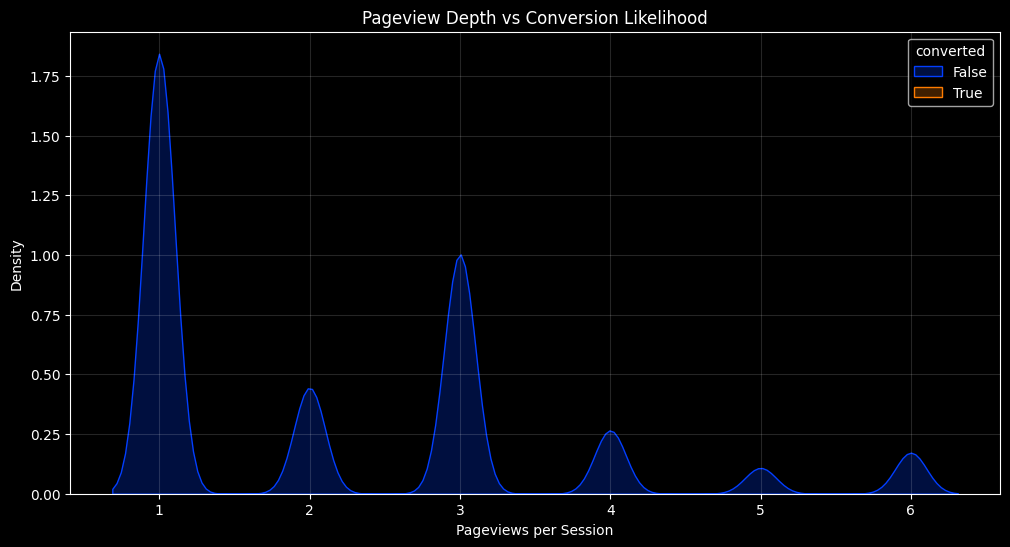

In [ ]:
session_behavior = (
    sessions_cleaned
    .merge(pageviews_cleaned, on="website_session_id")
    .merge(orders_cleaned[["website_session_id", "order_id"]],
           on="website_session_id", how="left")
    .groupby("website_session_id")
    .agg(
        pageviews=("website_pageview_id", "count"),
        converted=("order_id", lambda x: x.notnull().any())
    )
)

sns.kdeplot(
    data=session_behavior,
    x="pageviews",
    hue="converted",
    fill=True,
    common_norm=False
)

plt.title("Pageview Depth vs Conversion Likelihood")
plt.xlabel("Pageviews per Session")
plt.show()


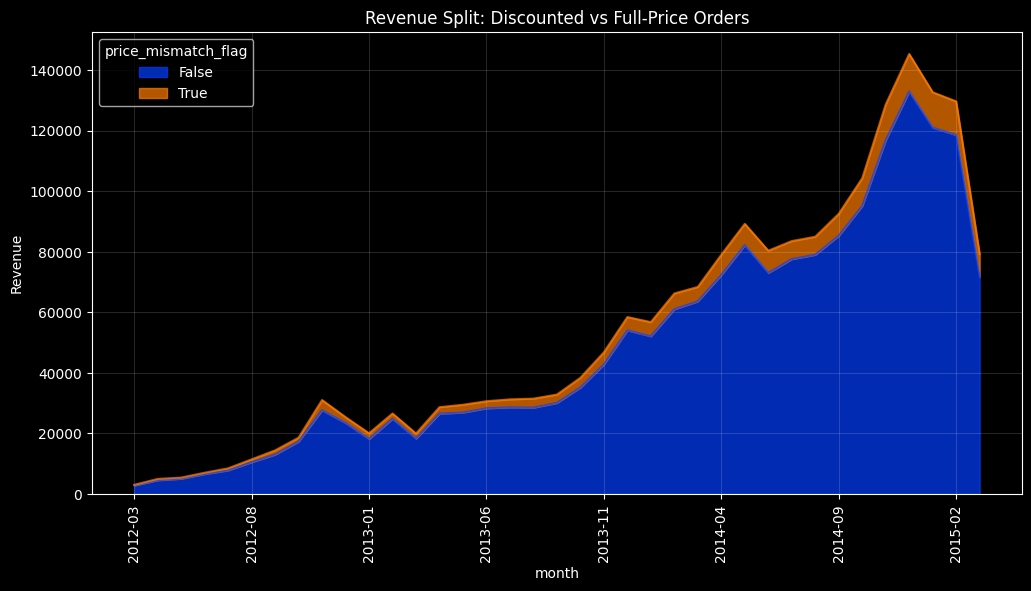

In [ ]:
discount_dependency = (
    orders_cleaned
    .groupby([orders_cleaned["created_at"].dt.to_period("M"),
              "price_mismatch_flag"])
    .agg(
        revenue=("price_usd", "sum"),
        orders=("order_id", "count")
    )
    .reset_index()
)

discount_dependency["month"] = discount_dependency["created_at"].astype(str)

pivot_rev = discount_dependency.pivot(
    index="month",
    columns="price_mismatch_flag",
    values="revenue"
)

pivot_rev.plot(kind="area", stacked=True, alpha=0.7)
plt.title("Revenue Split: Discounted vs Full-Price Orders")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.show()


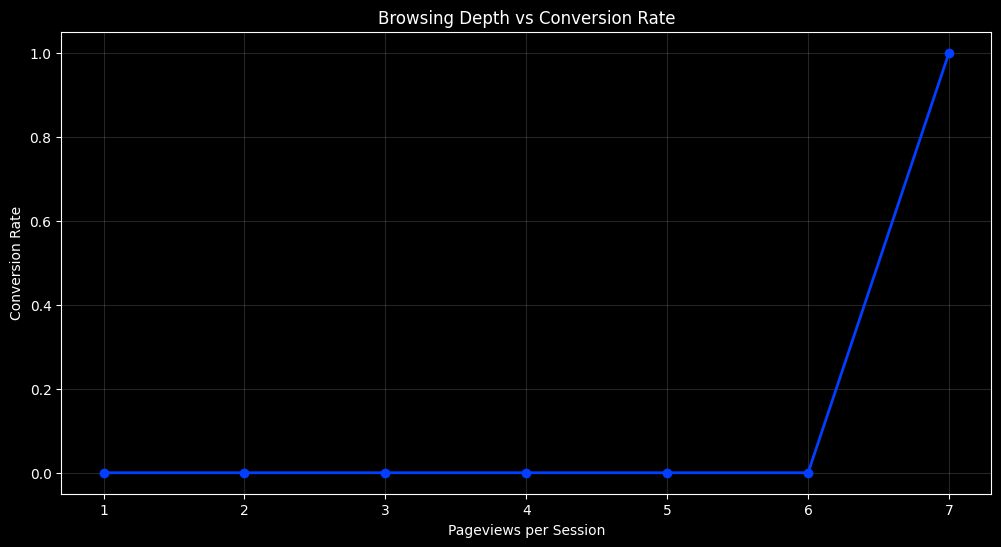

In [ ]:
funnel_depth = (
    sessions_cleaned
    .merge(pageviews_cleaned, on="website_session_id")
    .merge(orders_cleaned[["website_session_id", "order_id"]],
           on="website_session_id", how="left")
    .groupby("website_session_id")
    .agg(
        pageviews=("website_pageview_id", "count"),
        converted=("order_id", lambda x: x.notnull().any())
    )
)

depth_conversion = (
    funnel_depth
    .groupby("pageviews")["converted"]
    .mean()
    .reset_index()
)

plt.plot(depth_conversion["pageviews"],
         depth_conversion["converted"],
         marker="o",
         linewidth=2)

plt.xlabel("Pageviews per Session")
plt.ylabel("Conversion Rate")
plt.title("Browsing Depth vs Conversion Rate")
plt.show()


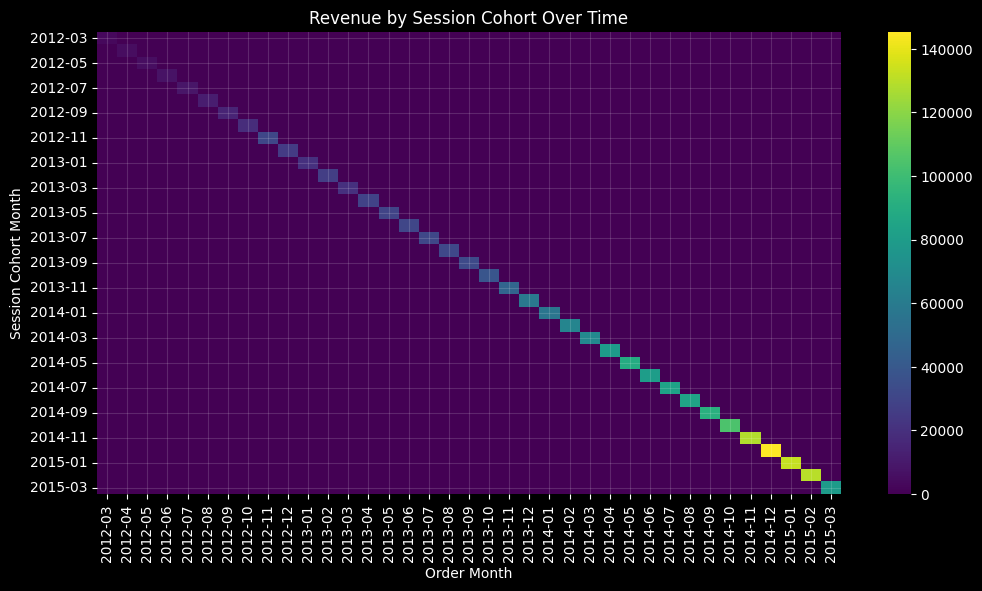

In [ ]:
sessions_cleaned["cohort_month"] = (
    sessions_cleaned["created_at"].dt.to_period("M")
)

orders_with_cohort = (
    orders_cleaned
    .merge(
        sessions_cleaned[["website_session_id", "cohort_month"]],
        on="website_session_id"
    )
)

orders_with_cohort["order_month"] = (
    orders_with_cohort["created_at"].dt.to_period("M")
)

cohort_data = (
    orders_with_cohort
    .groupby(["cohort_month", "order_month"])["price_usd"]
    .sum()
    .unstack(fill_value=0)
)

sns.heatmap(cohort_data, cmap="viridis")
plt.title("Revenue by Session Cohort Over Time")
plt.xlabel("Order Month")
plt.ylabel("Session Cohort Month")
plt.show()


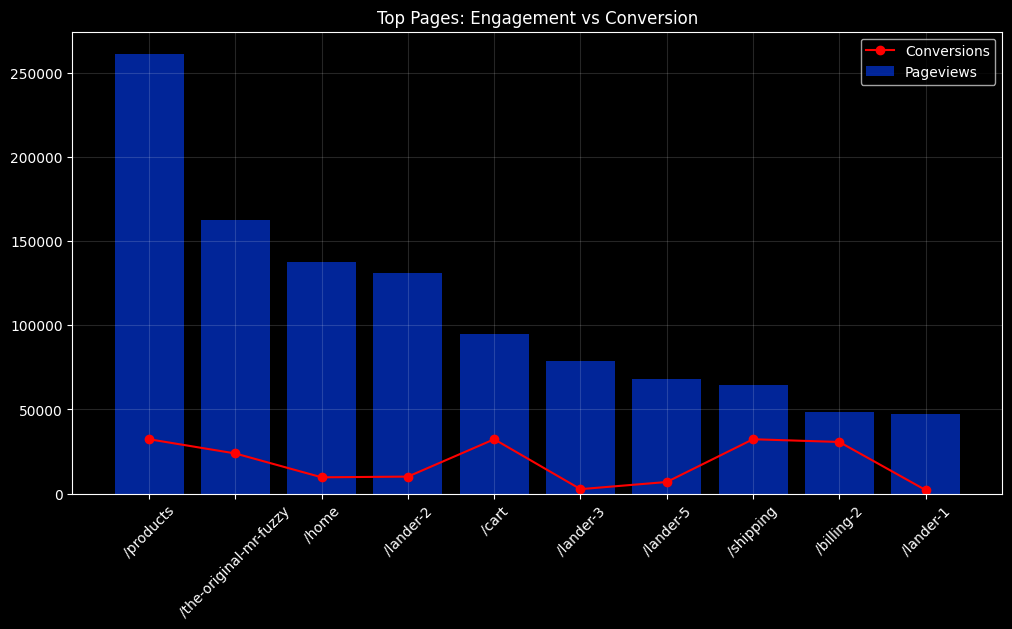

In [ ]:
page_behavior = (
    pageviews_cleaned
    .merge(orders_cleaned[["website_session_id", "order_id"]],
           on="website_session_id", how="left")
    .groupby("pageview_url")
    .agg(
        views=("website_pageview_id", "count"),
        conversions=("order_id", lambda x: x.notnull().sum())
    )
    .sort_values("views", ascending=False)
    .head(10)
)

plt.bar(page_behavior.index,
        page_behavior["views"],
        alpha=0.6,
        label="Pageviews")

plt.plot(page_behavior.index,
         page_behavior["conversions"],
         color="red",
         marker="o",
         label="Conversions")

plt.xticks(rotation=45)
plt.title("Top Pages: Engagement vs Conversion")
plt.legend()
plt.show()


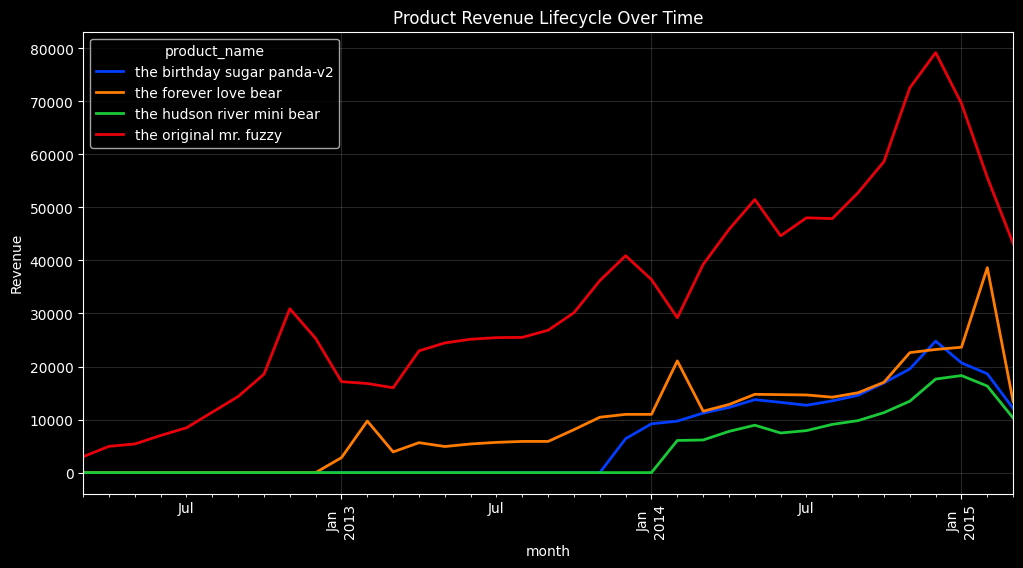

In [ ]:
# Step 1: Rename columns to make intent explicit
order_items_lc = order_items_cleaned.rename(
    columns={
        "price_usd": "item_price_usd",
        "created_at": "item_created_at"
    }
)

orders_lc = orders_cleaned.rename(
    columns={
        "created_at": "order_created_at"
    }
)

# Step 2: Build product lifecycle using ORDER time + ITEM revenue
product_lifecycle = (
    order_items_lc
    .merge(
        orders_lc[["order_id", "order_created_at"]],
        on="order_id"
    )
    .merge(
        products_cleaned,
        on="product_id"
    )
    .assign(
        month=lambda df: df["order_created_at"].dt.to_period("M")
    )
    .groupby(["month", "product_name"])["item_price_usd"]
    .sum()
    .unstack(fill_value=0)
)

# Step 3: Plot
product_lifecycle.plot(linewidth=2)
plt.title("Product Revenue Lifecycle Over Time")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.show()


In [ ]:
order_items_cleaned.columns


Index(['order_item_id', 'created_at', 'order_id', 'product_id',
       'is_primary_item', 'price_usd', 'cogs_usd', 'profit'],
      dtype='object')

In [ ]:
orders_cleaned.columns


Index(['order_id', 'created_at', 'website_session_id', 'user_id',
       'primary_product_id', 'items_purchased', 'price_usd', 'cogs_usd',
       'price_mismatch_flag', 'order_month', 'month'],
      dtype='object')

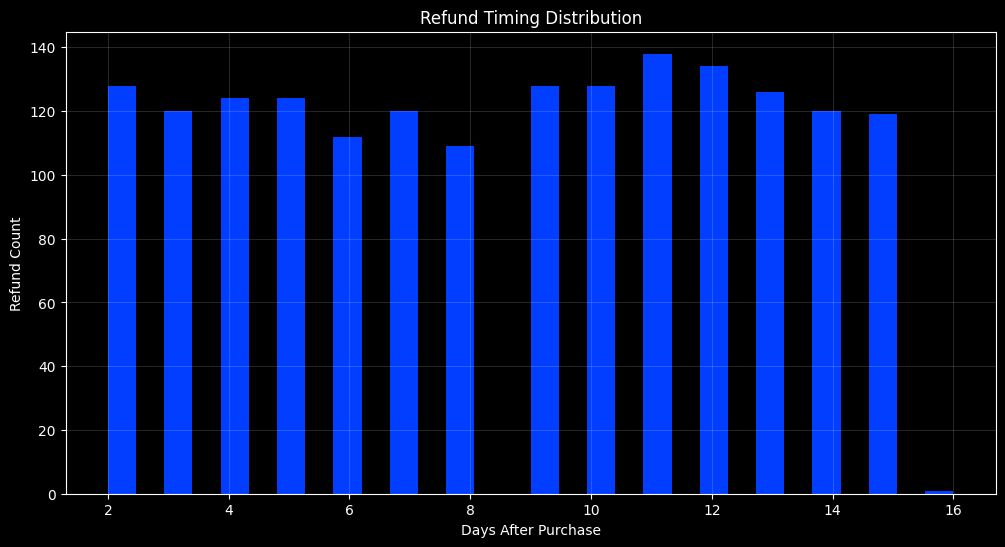

In [ ]:
refund_lag = (
    refunds_cleaned
    .merge(order_items_cleaned, on="order_item_id")
)

refund_lag["refund_delay_days"] = (
    refund_lag["created_at_x"] -
    refund_lag["created_at_y"]
).dt.days

plt.hist(refund_lag["refund_delay_days"], bins=30)
plt.xlabel("Days After Purchase")
plt.ylabel("Refund Count")
plt.title("Refund Timing Distribution")
plt.show()


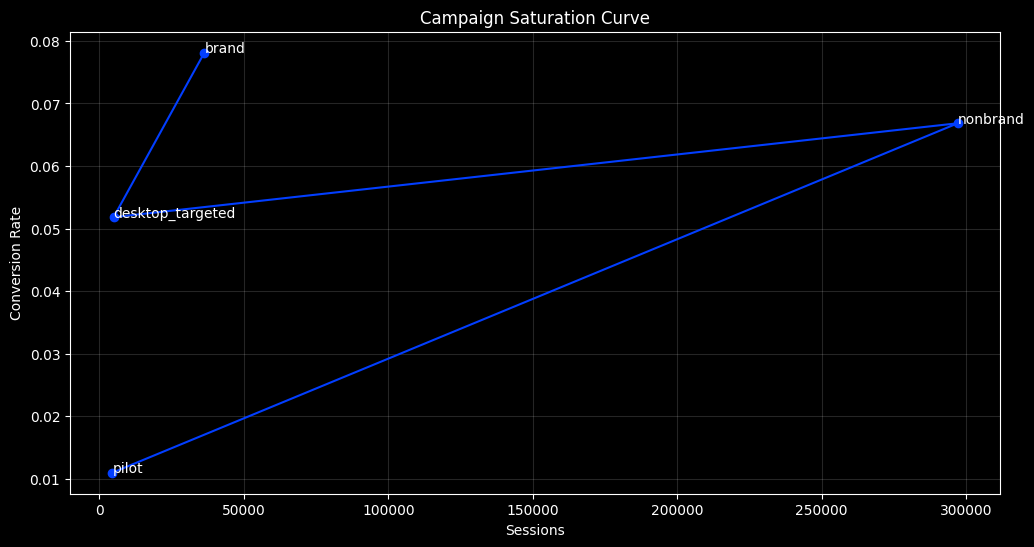

In [ ]:
campaign_curve = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id", how="left")
    .groupby("utm_campaign")
    .agg(
        sessions=("website_session_id", "nunique"),
        orders=("order_id", "nunique")
    )
)

campaign_curve["conversion_rate"] = (
    campaign_curve["orders"] / campaign_curve["sessions"]
)

plt.plot(campaign_curve["sessions"],
         campaign_curve["conversion_rate"],
         marker="o")

for c in campaign_curve.index:
    plt.annotate(c,
                 (campaign_curve.loc[c, "sessions"],
                  campaign_curve.loc[c, "conversion_rate"]))

plt.xlabel("Sessions")
plt.ylabel("Conversion Rate")
plt.title("Campaign Saturation Curve")
plt.show()


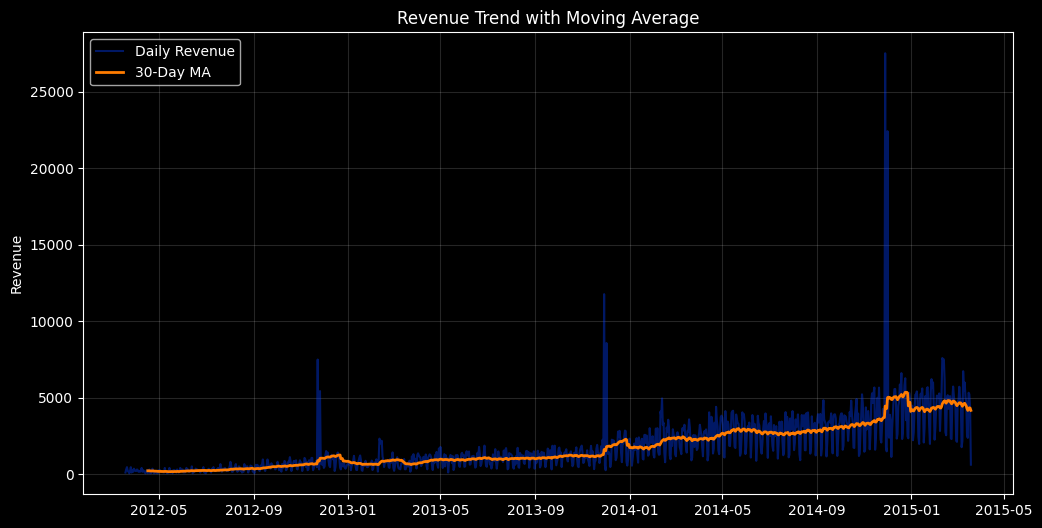

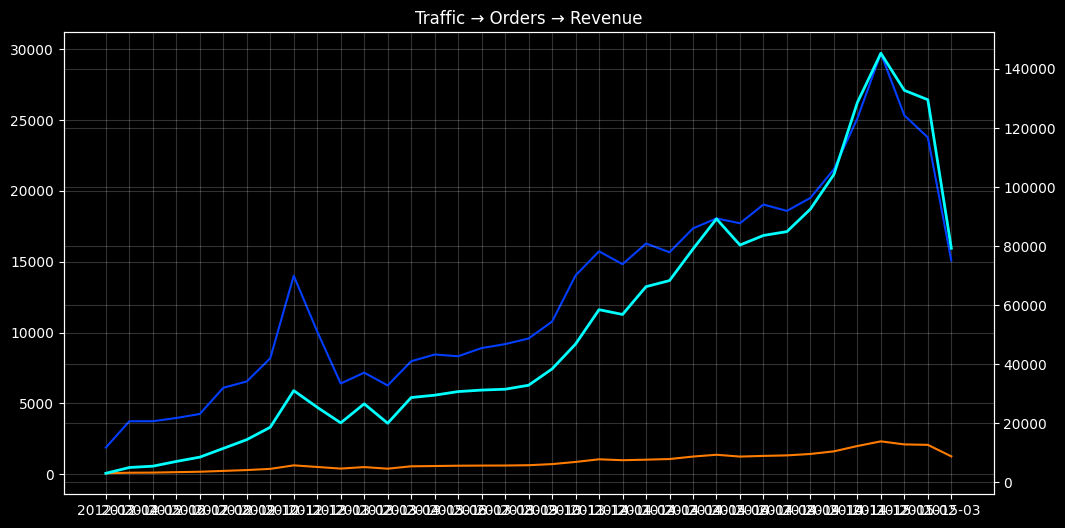

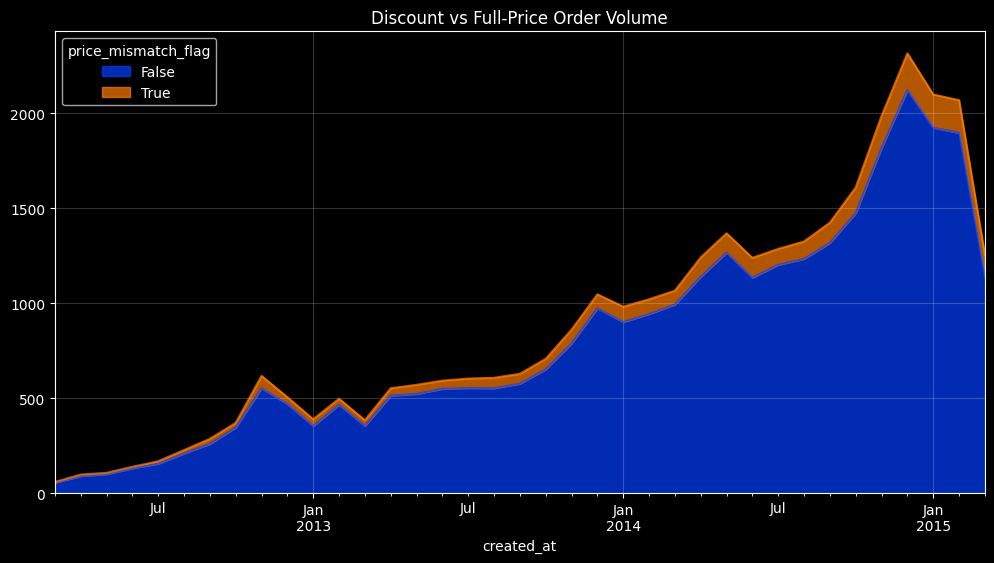

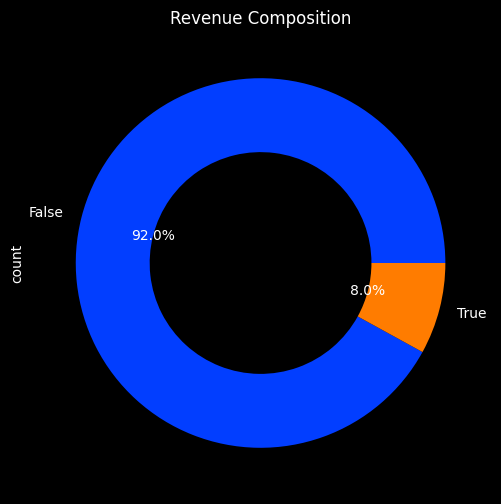

In [ ]:
orders_cleaned["price_mismatch_flag"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", wedgeprops=dict(width=0.4)
)
plt.title("Revenue Composition")
plt.show()


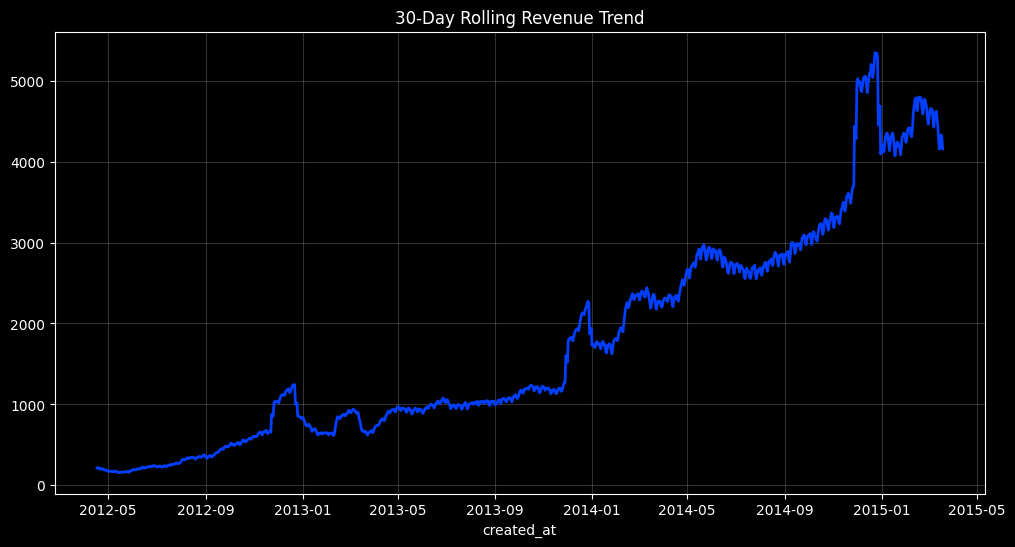

In [ ]:
daily_rev = orders_cleaned.groupby(orders_cleaned["created_at"].dt.date)["price_usd"].sum()
daily_rev.rolling(30).mean().plot(linewidth=2)
plt.title("30-Day Rolling Revenue Trend")
plt.show()


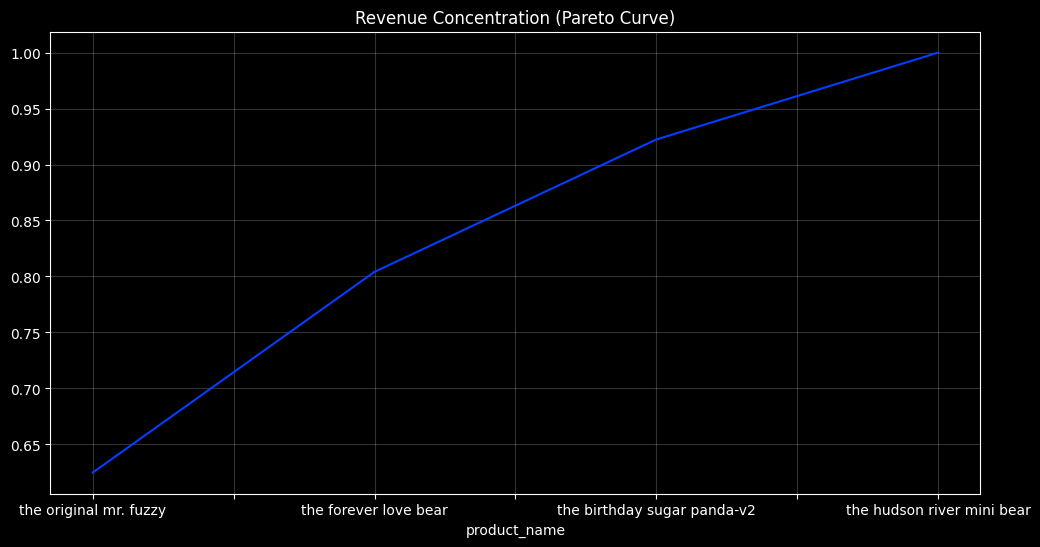

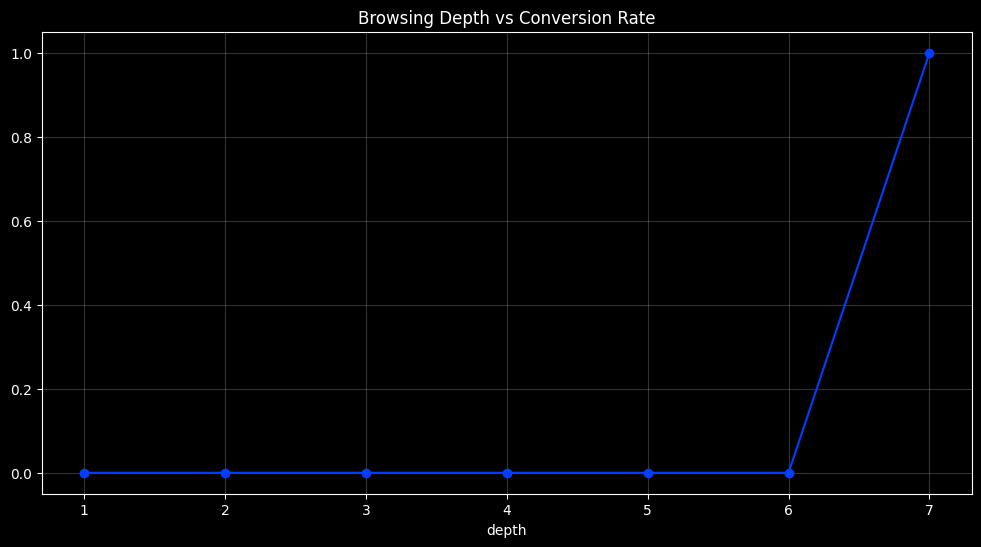

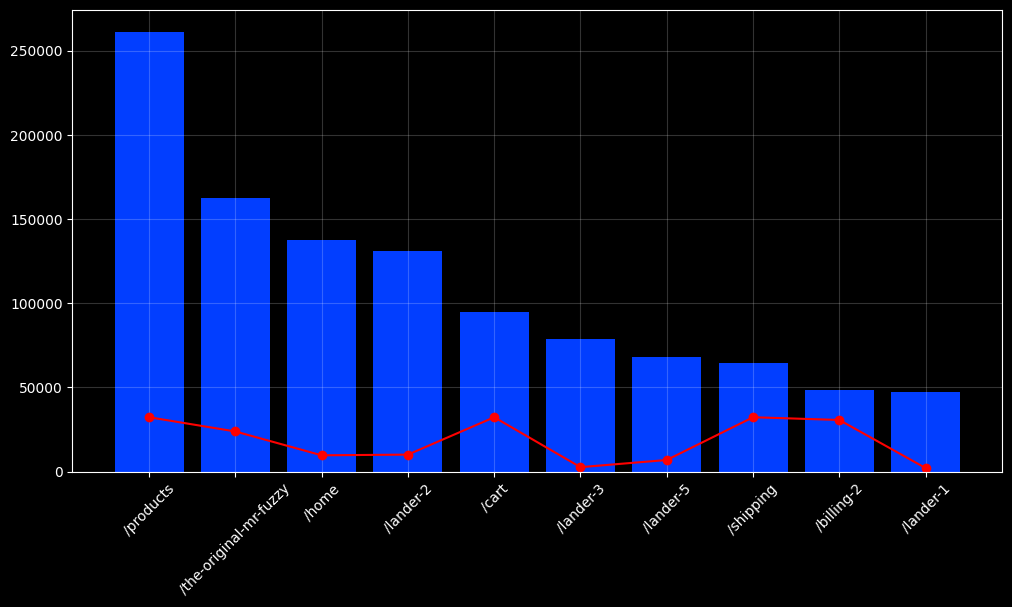

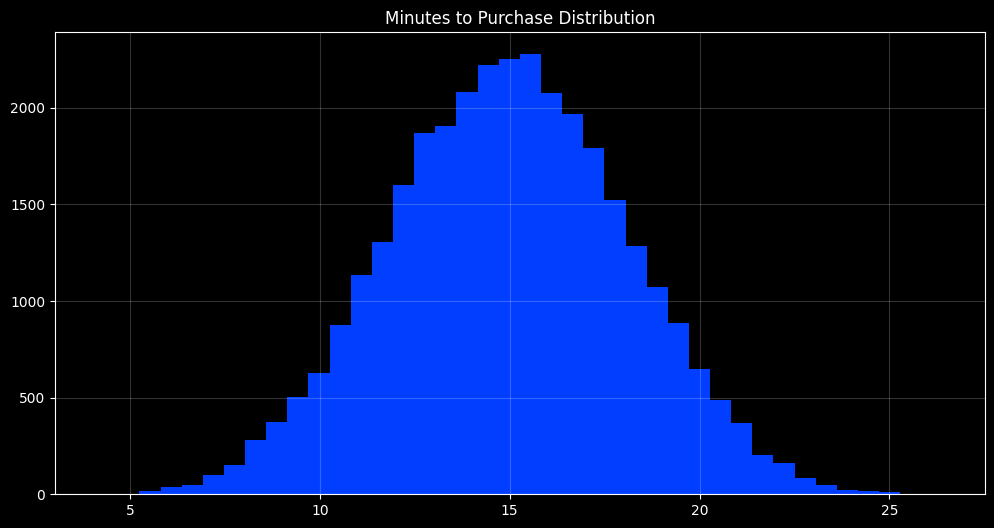

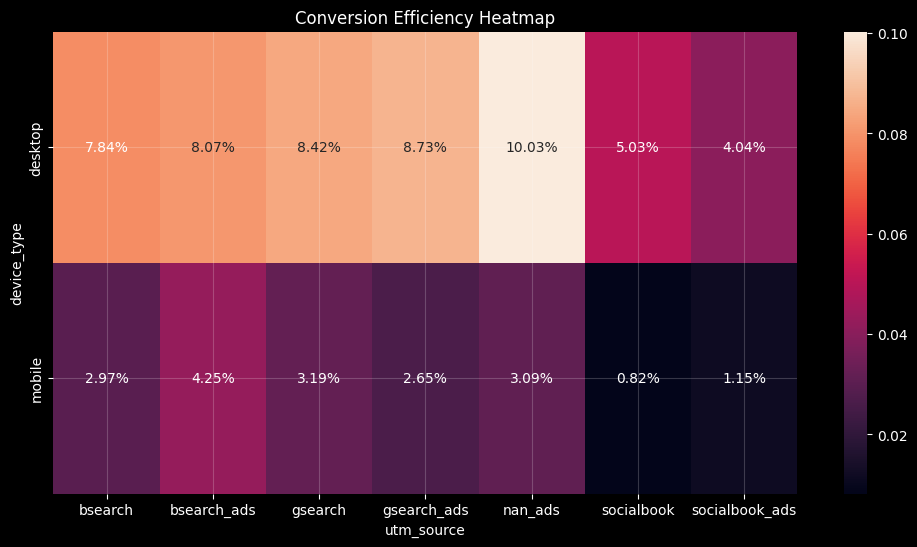

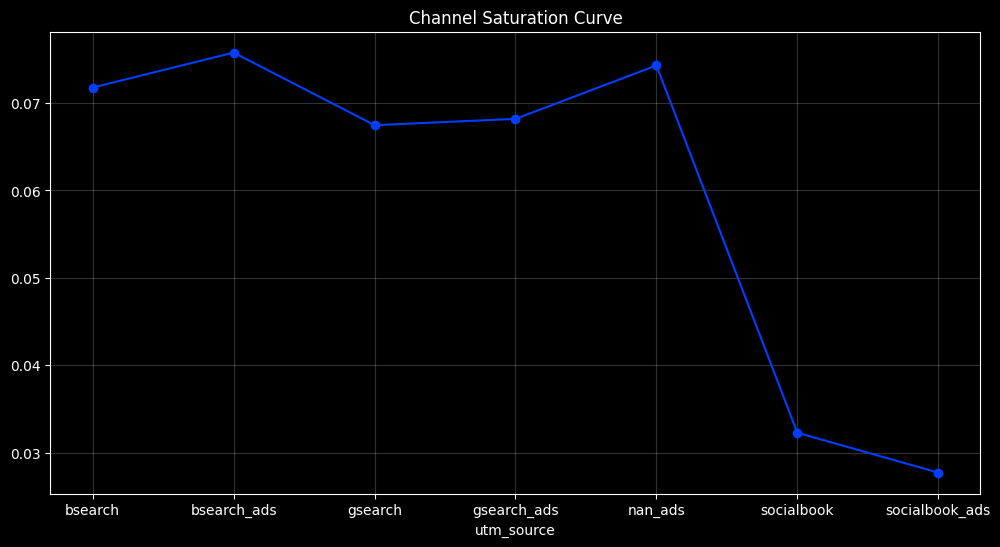

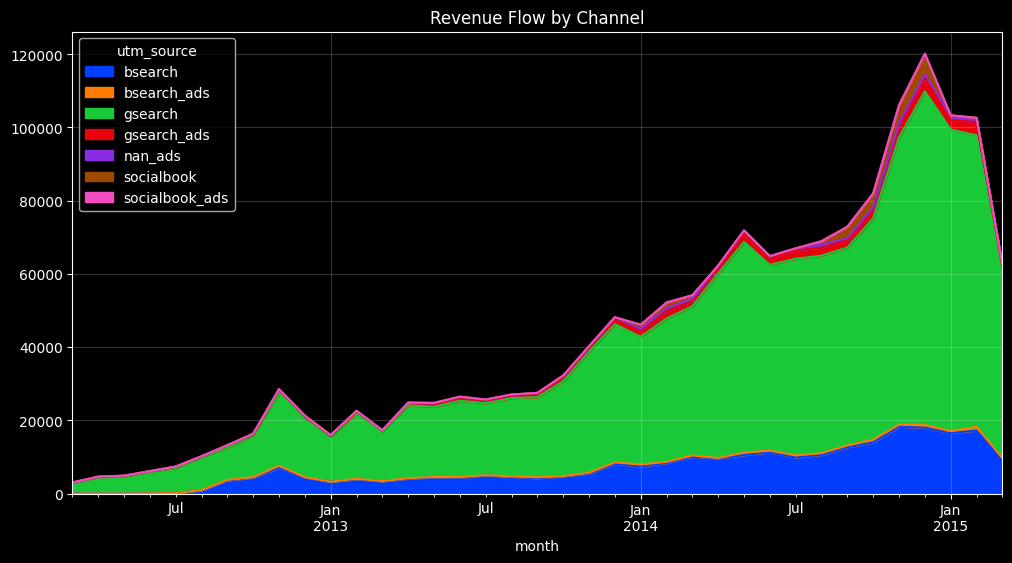

In [ ]:
chan_rev = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id")
    .assign(month=lambda d: d["created_at_y"].dt.to_period("M"))
    .groupby(["month","utm_source"])["price_usd"]
    .sum()
    .unstack(fill_value=0)
)

chan_rev.plot(kind="area", stacked=True)
plt.title("Revenue Flow by Channel")
plt.show()


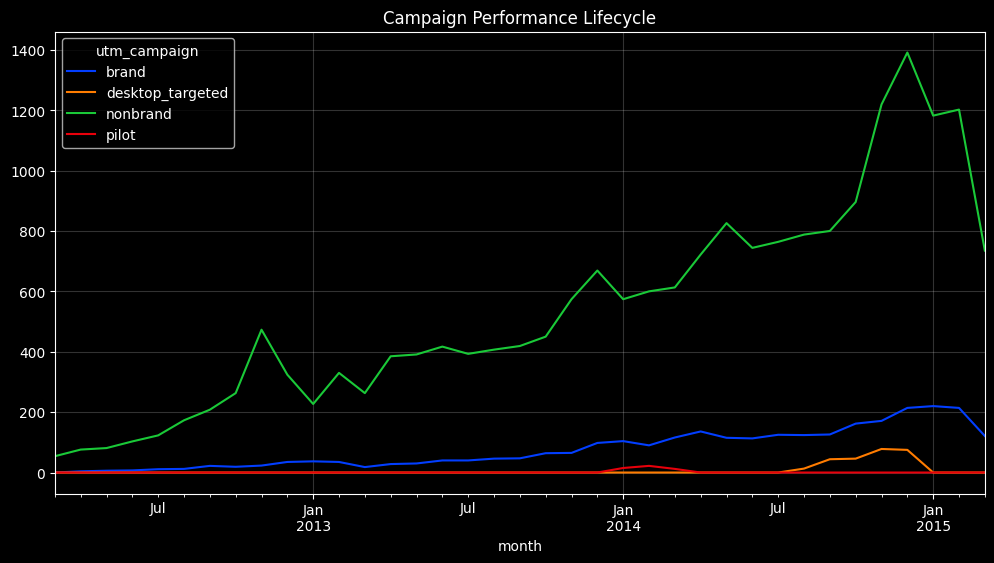

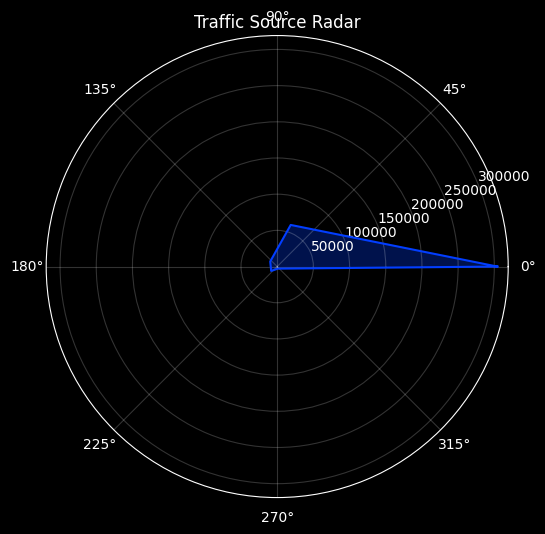

In [ ]:
labels = sessions_cleaned["utm_source"].value_counts().index[:5]
values = sessions_cleaned["utm_source"].value_counts().values[:5]

angles = np.linspace(0,2*np.pi,len(labels),endpoint=False)
values = np.append(values, values[0])
angles = np.append(angles, angles[0])

plt.polar(angles, values)
plt.fill(angles, values, alpha=0.3)
plt.title("Traffic Source Radar")
plt.show()


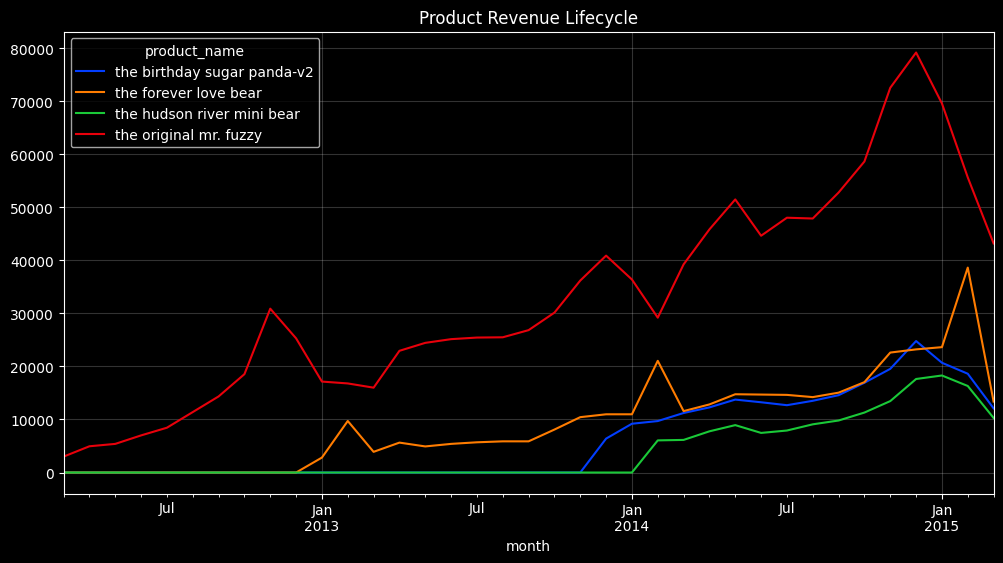

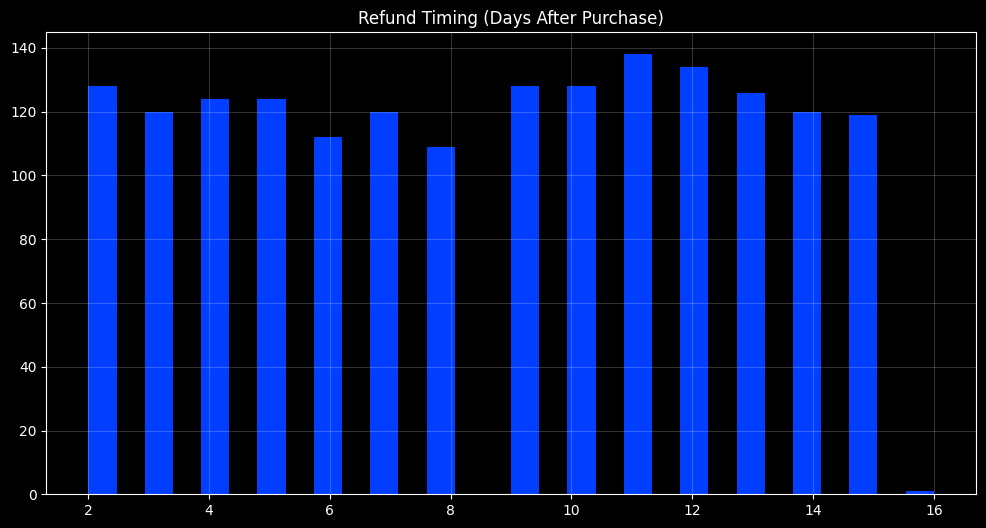

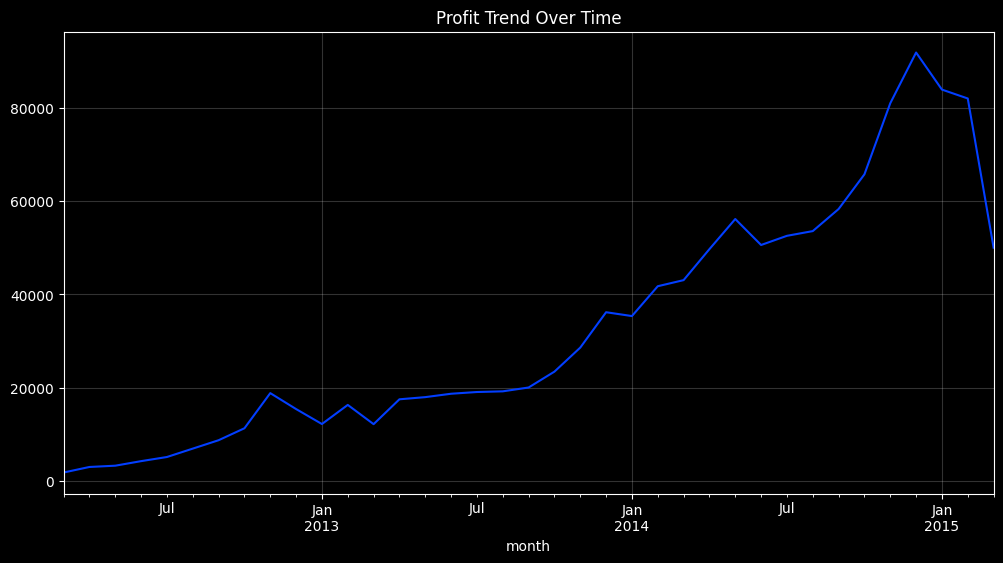

In [ ]:
profit_trend = (
    order_items_cleaned
    .merge(orders_lc[["order_id","order_created_at"]], on="order_id")
    .assign(month=lambda d: d["order_created_at"].dt.to_period("M"),
            profit=lambda d: d["price_usd"]-d["cogs_usd"])
    .groupby("month")["profit"]
    .sum()
)

profit_trend.plot()
plt.title("Profit Trend Over Time")
plt.show()


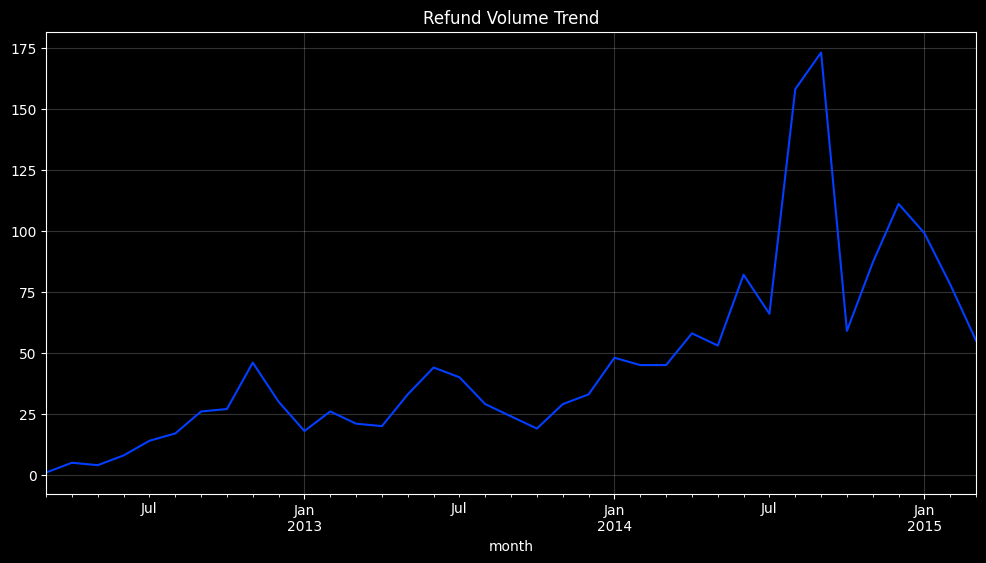

In [ ]:
refund_trend = (
    refunds_cleaned
    .merge(orders_lc[["order_id","order_created_at"]], on="order_id")
    .assign(month=lambda d: d["order_created_at"].dt.to_period("M"))
    .groupby("month")
    .size()
)

refund_trend.plot()
plt.title("Refund Volume Trend")
plt.show()


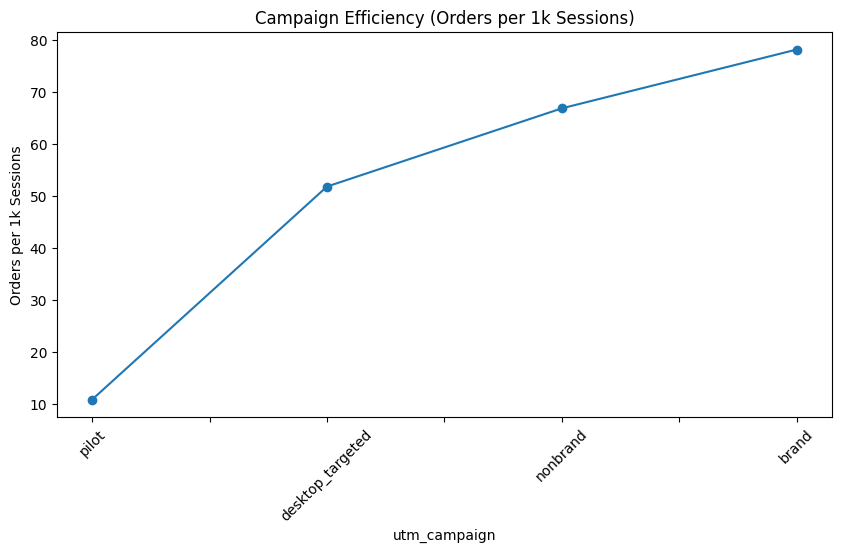

In [ ]:
campaign_efficiency = (
    sessions_cleaned
    .merge(orders_cleaned, on="website_session_id", how="left")
    .groupby("utm_campaign")
    .agg(
        sessions=("website_session_id", "nunique"),
        orders=("order_id", "nunique")
    )
)

campaign_efficiency["orders_per_1k_sessions"] = (
    campaign_efficiency["orders"] / campaign_efficiency["sessions"] * 1000
)

campaign_efficiency["orders_per_1k_sessions"].sort_values().plot(
    kind="line", marker="o"
)
plt.title("Campaign Efficiency (Orders per 1k Sessions)")
plt.ylabel("Orders per 1k Sessions")
plt.xticks(rotation=45)
plt.show()


NameError: name 'sessions_cleaned' is not defined

In [ ]:
# Explicit column intent
order_items_mv = order_items_cleaned.rename(
    columns={"price_usd": "item_revenue_usd"}
)

refunds_mv = refunds_cleaned.rename(
    columns={"refund_amount_usd": "refund_usd"}
)

orders_mv = orders_cleaned.rename(
    columns={"created_at": "order_created_at"}
)


In [ ]:
marketing_value = (
    sessions_cleaned
    .merge(orders_mv[["order_id","website_session_id","order_created_at"]],
           on="website_session_id", how="left")
    .merge(order_items_mv[["order_id","item_revenue_usd"]],
           on="order_id", how="left")
    .merge(refunds_mv[["order_id","refund_usd"]],
           on="order_id", how="left")
    .assign(
        month=lambda d: d["order_created_at"].dt.to_period("M"),
        net_revenue=lambda d:
            d["item_revenue_usd"].fillna(0) -
            d["refund_usd"].fillna(0)
    )
    .groupby(["month","utm_source"])["net_revenue"]
    .sum()
    .unstack(fill_value=0)
)


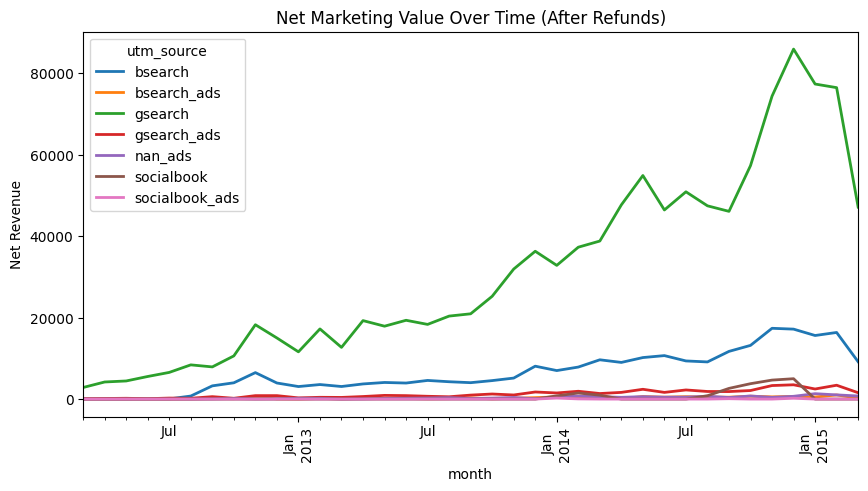

In [ ]:
marketing_value.plot(linewidth=2)
plt.title("Net Marketing Value Over Time (After Refunds)")
plt.ylabel("Net Revenue")
plt.xticks(rotation=90)
plt.show()
